TODO:
2. lemmatize? [[1](https://github.com/synhershko/HebMorph),[2](https://docs.hebrew-nlp.co.il/#/Morph/Normalize)]
3. remove non-informative words (especially if using clustering rather than classification)
5. look for word embedding [[1](https://github.com/NLPH/NLPH_Resources#embeddings),[2](https://github.com/liorshk/wordembedding-hebrew)]
6. understand deep LDA from [reference](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05) (possibly different embedding); go over [gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
7. use other features in addition to words counters (e.g. length, english words, numbers, etc.)
8. only parse "important" sections (e.g. intro & summary)
9. detect entities to increase weight of corresponding tokens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords

In [3]:
mpl.rcParams.update({'font.size': 13})

In [4]:
DO_PARSE = False
SAVE_PARSER = False

# Load data

In [5]:
%%time
DATA = Path('Data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

Wall time: 37.2 s


In [6]:
if len(meta)!=len(np.unique(df.ID)):
    warn(f'Inconsistent dimensions! {len(meta):d}!={len(np.unique(df.ID)):d}')

# Parser

In [7]:
from Parser import Parser, show_freqs, ordered_counter, EXTRA_STOPWORDS

In [8]:
%%time
if DO_PARSE:
    print('Parsing...')
    p = Parser(df, meta, max_voc_size=5000)
    if SAVE_PARSER:
        p.save()
else:
    print('Loading...')
    p = Parser(do_init=0, max_voc_size=5000)
    p.load()

Parsing...


100%|█████████████████████████████████████████████████████████████████████| 6760339/6760339 [07:41<00:00, 14659.14it/s]


Vocabulary: 5000'th word => 5571 occurences.
Vocabulary: 10 occurences => 245433 words.


100%|████████████████████████████████████████████████████████████████████████████| 37177/37177 [11:52<00:00, 52.19it/s]


Wall time: 32min 53s


# EDA

C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


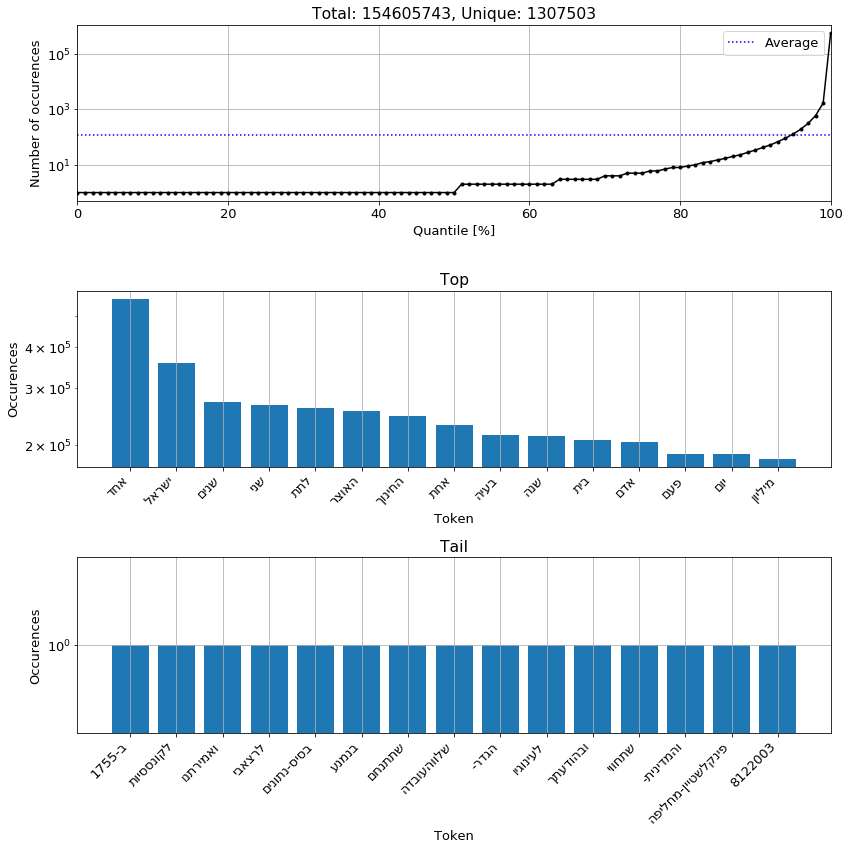

In [9]:
p.show_tokens()

In [10]:
p.profile if p.profile else ordered_counter(p.tokens)

OrderedDict([('אחד', 562971),
             ('ישראל', 356691),
             ('שנים', 271622),
             ('שני', 266047),
             ('לתת', 259782),
             ('האוצר', 253879),
             ('החינוך', 245784),
             ('אחת', 230769),
             ('בעיה', 214982),
             ('שנה', 213232),
             ('בית', 207470),
             ('אדם', 204154),
             ('פעם', 187973),
             ('יום', 187824),
             ('מיליון', 181696),
             ('מספר', 159384),
             ('רשות', 157991),
             ('העבודה', 154181),
             ('השאלה', 154086),
             ('שקל', 153339),
             ('דיון', 153286),
             ('הבעיה', 151445),
             ('שקלים', 150341),
             ('זמן', 146352),
             ('עובדים', 143351),
             ('כסף', 142957),
             ('מקום', 142212),
             ('עבודה', 142185),
             ('המשפט', 140380),
             ('מציע', 138851),
             ('הבריאות', 133696),
             ('הפנים', 128482),
 

#### Encoding and PCA

In [11]:
p.one_hot.head()

,---,-----------------------הכנסת,1,10,10%,100,100%,1000,10000,11,...,תשומת,תשלום,תשלומי,תשלומים,תשלם,תשמע,תשעה,תשתיות,תשתית,תתקבל
0,0,0,4,4,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,4,0,0,0,0,2,1,0,...,2,0,0,0,0,3,0,0,0,0
2,0,0,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,2,0,0,0,2,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,3,0,0,0,0,2,0,2,...,0,2,0,0,0,0,0,0,0,0


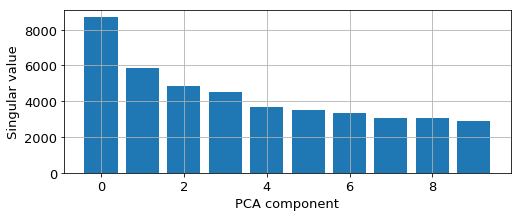

In [12]:
from sklearn.decomposition import PCA
n_comps = 10
pca = PCA(n_components=n_comps)
pca.fit(p.one_hot)
plt.figure(figsize=(8,3))
plt.bar(list(range(n_comps)), pca.singular_values_)
plt.xlabel('PCA component')
plt.ylabel('Singular value')
plt.grid()
X2D = np.matmul(p.one_hot.as_matrix(), pca.components_[:2,:].transpose())
X3D = np.matmul(p.one_hot.as_matrix(), pca.components_[:3,:].transpose())

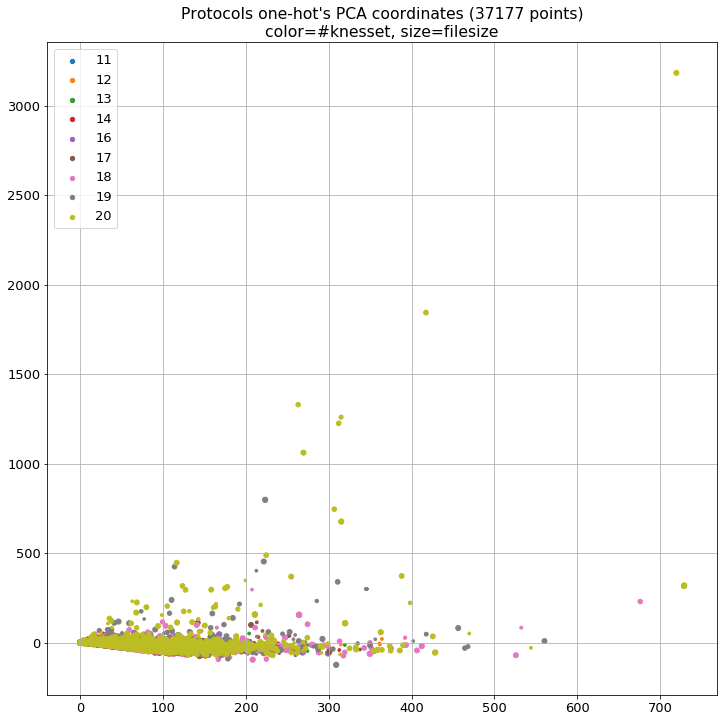

In [13]:
_, ax = plt.subplots(1,1, figsize=(12,12))

for grp in np.unique(meta[meta.ID.isin(df.ID)].KnessetNum): # TODO color by committee name rather than KnessetNum once available
    X = X2D[np.where(meta[meta.ID.isin(df.ID)].KnessetNum==grp),:].reshape(-1,2)
    sc = ax.scatter(X[:,0], X[:,1], s=np.log10(meta[meta.ID.isin(df.ID)].filesize)**2, label=int(grp))
    
ax.set_title(f"Protocols one-hot's PCA coordinates ({X2D.shape[0]:d} points)\ncolor=#knesset, size=filesize")
ax.grid()
ax.legend()

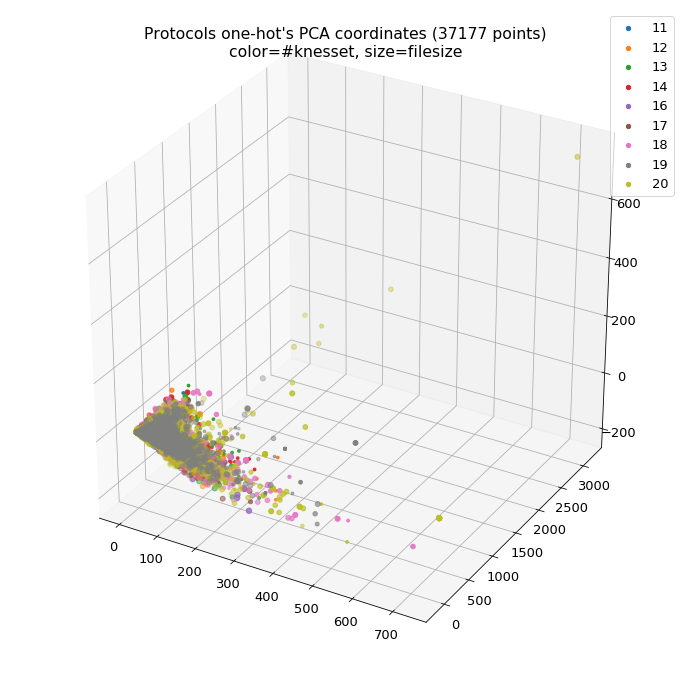

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='3d')

for grp in np.unique(meta[meta.ID.isin(df.ID)].KnessetNum):
    X = X3D[np.where(meta[meta.ID.isin(df.ID)].KnessetNum==grp),:].reshape(-1,3)
    ax.scatter(X[:,0],X[:,1],X[:,2], label=int(grp),
               s=np.log10(meta[meta.ID.isin(df.ID)].filesize)**2)#, c=meta[meta.ID.isin(df.ID)].KnessetNum)
    
ax.set_title(f"Protocols one-hot's PCA coordinates ({X3D.shape[0]:d} points)\ncolor=#knesset, size=filesize")
ax.grid()
ax.legend()

#### Print some random protocols

In [15]:
print(p.full_protocol())

________
:
הכנסת העשרים

מושב שני

פרוטוקול מס' 89

מישיבת הוועדה לזכויות הילד

יום ראשון, י"א בתמוז התשע"ו (17 ביולי 2016), שעה 14:00

________
סדר היום:
ביקור בעמותת 'הגל שלי' - לטיפול בנוער בסיכון

________
נכחו:


________
חברי הוועדה::
יפעת שאשא ביטון – היו"ר

________
מוזמנים::
שושי גורדון - מרכזת תחום טיפול בנוער, מחוז ת"א והמרכז, משרד הרווחה

רותי שוורץ - מנהלת יחידת רונ"ן, קידום נוער ומשרד הרווחה

ירון נסגי - מפקח מחוזי בשירות לנוער, משרד הרווחה

ירון וקסמן - ממקימי ומנהל העמותה 'הגל שלי'

עומר טולצ'ינסקי - ממקימי ומנהל העמותה 'הגל שלי'

אלעד גולדמן - מנהל אדמיניסטרטיבי, עמותת 'הגל שלי'

לרשימת השדלנים שנכחו בדיון – ראו בקישור זה.

________
מנהלת הוועדה:
תמי ברנע

________
רישום פרלמנטרי:
סמדר לביא, חבר המתרגמים

ביקור בעמותת 'הגל שלי' - לטיפול בנוער בסיכון

________
ירון וקסמן:
נשמח לשתף אתכם בסיפור שלנו, במסע שלנו.

________
היו"ר יפעת שאשא ביטון:
עצרו שנייה רגע, אני אשאל אתכם שאלה שלא שאלתי אף פעם, בני כמה אתם?

________
ירון וקסמן:
אני בן 29 ועומר בן 30.

________
היו"ר יפ

 הישיבה ננעלה בשעה 14:45.


In [16]:
print(p.full_protocol())

________
:
p_ilana

2007-12-09Liraz



הכנסת השבע-עשרה נוסח לא מתוקן

מושב שלישי

פרוטוקול מס' 322





מישיבת ועדת העבודה, הרווחה והבריאות

‏יום שני, כ"ג בכסלו התשס"ח (‏3 בדצמבר, 2007), שעה 10:30



סדר היום: 1. הצעת חוק השתלת אברים, התשס"ד-2003 – עלות תקציבית של ההסתייגות של חה"כ רביץ לסעיף 22 בהצעת החוק

________
נכחו:
חברי הוועדה: יצחק גלנטי – היו"ר

אריה אלדד

אברהם רביץ

מוזמנים: עו"ד מאיר ברודר - הלשכה המשפטית, משרד הבריאות

עו"ד נתן סמוך - הלשכה המשפטית, משרד הבריאות

אנואר חילף - רפרנט בריאות, אגף התקציבים, משרד האוצר

עו"ד טלי שטיין - משרד המשפטים

עו"ד אדי וייס - סגן היועצת המשפטית, משרד הרווחה והשירותים החברתיים

אדוארד קורצנשטיין - ראש הצוות הכלכלי, מחלקת המחקר והמידע של הכנסת

מרק ויין - מחלקת המחקר והמידע של הכנסת

ייעוץ משפטי: ג'ודי וסרמן

 איתי עצמון

מנהלת הוועדה: וילמה מאור

רשמת פרלמנטרית: אירית שלהבת

הצעת חוק השתלת אברים, התשס"ד-2003

עלות תקציבית של ההסתייגות של חה"כ רביץ לסעיף 22 בהצעת החוק

________
היו"ר יצחק גלנטי:
אני מתכבד לפתוח את ישיבת ועדת העבודה, הרווחה

In [17]:
print(p.full_protocol())

________
:
imst

2008-06-15dbq



-----------------------הכנסת הארבע-עשרה

מושב שני

נוסח לא מתוקן

פרוטוקול מס' 106

מישיבת ועדת החינוך והתרבות

יום שלישי. כ"ד בתמוז התשנ"ז (29 ביולי 1997), שעה 10:00

________
נכחו:
חברי הוועדה: עמנואל זיסמן - היו"ר

רפאל אלול

זאב בוים

שמריהו בן-צור

שמואל הלפרט

האשם מחמיד

ואליד צאדק חאג' יחיא

ראובן ריבלין

מוזמנים: חה"כ סאלה טריף

מוטי קירשנבאום - מנכ"ל רשות השידור

יוסף בינייא - מנהל הטלוויזיה בערבית

סמי חלבי - חבר מליאת רשות השידור

סלמאן טאויל - הטלוויזיה בערבית - חיפה

יחזקאל יעקבי - כתב הטלוויזיה הישראלית

משה צור - מנהל חטיבת החדשות בערבית

מנהלת הוועדה: יהודית גידלי

קצרנית: הילה לוי

סדר-היום: מצב הטלוויזיה בערבית.

מצב הטלוויזיה בערבית

________
היו"ר עמנואל זיסמן:
בוקר טוב, אני פיתח את ישיבת הו ועדי;. אני מבקש מכם להיות נוכחים בישיבה

שתתקיים כאן היום בשעה 12:00, לגבי תשלומי ההורים, ויש הישג לוועדת ההינוך בנושא

זה.

הנושא שנדון בו היום הוא ביוזמת חבר הכנסת סאלח טריף. הנושא הזה לא בא כמקובל

מהמליאה, אבל אם יש נושא שראוי לדיון, גם אם 

הישיבה ננעלה בשעה 11:35.


In [18]:
print(p.full_protocol())

________
:
imst

2008-06-26dbq



-----------------------הכנסת השתים-עשרה

מושב שני

נוסח לא מתוקן

פרוטוקול מס' 22

מישיבת ועדת החינוך והתרבות

שהתקיימה ביום ב'. י"ג בחשוון. התשנ"ג. 9.11.92

נכחו; חברי הוועדה; אי בורג - היו"ר

י' בא-גד

ת' גוז'נסקי

שי יהלום

וי חאג' יחיא

אי יחזקאל

לי לבנת

חי מירום

הי מחאמיד

עי מאור

אי קהלני

אי סלמוביץ

מוזמנים; אי בריק - היועץ המשפטי של משרד החינוך והתרבות

ד' שוחט - היחידה לדמוקרטיה ולדו-קיום, משרד החינוך

חי מרון - ארגון המורים

חי לבנה, גי לוי, יי מנוכין - ארגון יש גבול

חי קציר, אי יושע - ארגון נגד החזרת הגולן

פי שומר - ההסתדרות הכללית

אי הילווייל, די אברהם, י' מונדלך - מועצת תלמידים

ארצית

מזכיר הוועדה; יי גידלי

קצרנית; שי לחוביצקי

סדר-היום;

א. החלת חוק רציפות על הצעות חוק.

ב. פוליטיקה במערכת החינוך.

היו"ר א' בורג;

בוקר טוב, אני מתכבד לפתוח את ישיבת ועדת החינוך והתרבות של הכנסת. הנושא

כפי שהוגדר הוא "פוליטיקה במערכת החינוך". יותר מאוחר אגדיר את הנושא בצורה יותר

מדוייקת,

________
בפנינו נושא נוסף שהוכנס לסדר היום:
א. החלת הרציפ

*
